# **UGain ML Tree-based Models Exercise Solutions Notebook**

## **Import Libraries**

In [1]:
!pip install auto-sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.5 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 260 kB 40.9 MB/s 
     |████████████████████████████████| 4.4 MB 27.3 MB/s 
     |████████████████████████████████| 4.3 MB 47.6 MB/s 
     |████████████████████████████████| 22.3 MB 2.2 MB/s 
     |████████████████████████████████| 46 kB 3.6 MB/s 
  Created wheel for auto-sklearn: filename=auto_sklearn-0.15.0-py3-none-any.whl size=6641946 sha256=7aa529a78a499e3ff204fbdf967c33c01c5fc2d6ebe1fc2e0b3de6c94642189a
  Stored in directory: /root/.cache/pip/wheels/26/57/ce/ca63ad74b90273f9a682028d187645a42dce5c5255228d46c8
  Created wheel for pynisher: filename=pynisher-0.6.4-py3-none-any.whl size=7043 sha256=25d6d7fe6743b79d9b265dc65812e03e6ea98f08b4780fbeaec53deaf0e87248
  Sto

In [3]:
# Auto-Sklearn

# Basic libraries
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

# Sklearn
## Data
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

## Models
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

## Model Explaination
from sklearn.inspection import permutation_importance

## Metrics
from sklearn.metrics import mean_squared_error

# XGBoost
import xgboost

# Plotting
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# Auto-Sklearn
try:
  import autosklearn.regression
  import autosklearn.metrics
finally:
  import autosklearn.regression
  import autosklearn.metrics

## **Load Dataset**

In [4]:
# Load dataset
diabetes_data = load_diabetes()
predictors = diabetes_data['data']
labels = diabetes_data['target']

# Print description of the dataset
print(diabetes_data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [5]:
# Parameters
seed = 0

# Train - Test Split
X_train, X_test, y_train, y_test = train_test_split(predictors, 
                                                    labels, 
                                                    random_state=seed)

## **Exercises**

In [6]:
# Utility functions
from sklearn.metrics import make_scorer

def get_rmse(model, predictors, labels):
  predictions = model.predict(predictors)
  rmse = mean_squared_error(labels, predictions, squared=False)
  return rmse

def rmse_loss(true_labels, pred_labels):
  return mean_squared_error(true_labels, pred_labels, squared=False)

score_function_decision_tree = make_scorer(rmse_loss, greater_is_better=False)


### **Exercise 1a: Fit Decision Tree (Regression)**

In [7]:
# Create decision tree regressor object
decision_tree_regressor = tree.DecisionTreeRegressor(random_state=seed)

# Fit the training data to the regressor
decision_tree_regressor = decision_tree_regressor.fit(X_train, y_train)

# Calculate root mean square error of the train and test sets
train_rmse = get_rmse(decision_tree_regressor, X_train, y_train)
test_rmse = get_rmse(decision_tree_regressor, X_test, y_test)

# Verbose
print("Train set root mean squared error is: {} and test set root mean squared error is: {}".format(round(train_rmse, 4), 
                                                                                                    round(test_rmse, 4)))

Train set root mean squared error is: 0.0 and test set root mean squared error is: 77.4409


### **Exercise 1b: Search for the Best Cost-Complexity Pruning (alpha)**

In [8]:
# Call built-in method to compute the pruning path during Minimal Cost-Complexity Pruning.
path = decision_tree_regressor.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Define parameter space to search
param_grid = { 
    'ccp_alpha': ccp_alphas,}

# Create decision tree regressor object
decision_tree_regressor = tree.DecisionTreeRegressor(random_state=seed)

# Perform grid search in the defined parameter space with cross validation
CV_decision_tree_regressor = GridSearchCV(estimator=decision_tree_regressor, 
                                          param_grid=param_grid, 
                                          cv= 5, 
                                          scoring=score_function_decision_tree)
CV_decision_tree_regressor.fit(predictors, labels)

# Verbose best parameters from the GridSearchCV
print('Best Parameters:', CV_decision_tree_regressor.best_params_)

# Fit decision tree regressor model with best parameters
decision_tree_regressor = tree.DecisionTreeRegressor(random_state=seed,
                                                       **CV_decision_tree_regressor.best_params_)
decision_tree_regressor = decision_tree_regressor.fit(X_train, y_train)

# Calculate root mean square error of the train and test sets
train_rmse = get_rmse(decision_tree_regressor, X_train, y_train)
test_rmse = get_rmse(decision_tree_regressor, X_test, y_test)

# Verbose
print("Train set root mean squared error is: {} and test set root mean squared error is: {}".format(round(train_rmse, 4), 
                                                                                                    round(test_rmse, 4)))

Best Parameters: {'ccp_alpha': 208.74061453741638}
Train set root mean squared error is: 56.1185 and test set root mean squared error is: 66.6557


### **Exercise 2a: Fit an Ensemble Model of Your Choice (Regression)**

Helpful to search regression ensemble models, use websites;
1. https://scikit-learn.org/stable/modules/ensemble.html
2. https://xgboost.readthedocs.io/en/stable/python/python_api.html

In [11]:
# Create a XGBoost regressor object
xgboost_regressor = xgboost.XGBRegressor(objective ='reg:squarederror')

# Fit the training data to the XGBoost regressor
xgboost_regressor = xgboost_regressor.fit(X_train, y_train)

# Calculate root mean square error of the train and test sets
train_rmse = get_rmse(xgboost_regressor, X_train, y_train)
test_rmse = get_rmse(xgboost_regressor, X_test, y_test)
print("Train set root mean squared error is: {} and test set root mean squared error is: {}".format(round(train_rmse, 4), 
                                                                                                    round(test_rmse, 4)))

Train set root mean squared error is: 29.122 and test set root mean squared error is: 62.0087


### **Exercise 2b: Search Hyperparameter Space of your Choice of Model**

In [12]:
# Define parameter space to search
param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.1, 0.3, 0.5, 0.7],
    'min_child_weight': [1, 10, 100, 200, 500],
    'colsample_bytree': [0.1, 0.3, 0.7],
}

# Create XGBoost regressor object
xgboost_regressor = xgboost.XGBRegressor(objective ='reg:squarederror')

# Perform grid search in the defined parameter space with cross validation
CV_xgboost_regressor = GridSearchCV(estimator=xgboost_regressor, 
                                    param_grid=param_grid, 
                                    cv= 5, 
                                    scoring=score_function_decision_tree)
CV_xgboost_regressor.fit(predictors, labels)

# Verbose best parameters from the GridSearchCV
print('Best Parameters:', CV_xgboost_regressor.best_params_)

# Fit XGBoost regressor model with best parameters
xgboost_regressor = xgboost.XGBRegressor(objective ='reg:squarederror',
                                         **CV_xgboost_regressor.best_params_)
xgboost_regressor = xgboost_regressor.fit(X_train, y_train)

# Calculate root mean square error of the train and test sets
train_rmse = get_rmse(xgboost_regressor, X_train, y_train)
test_rmse = get_rmse(xgboost_regressor, X_test, y_test)

# Verbose
print("Train set root mean squared error is: {} and test set root mean squared error is: {}".format(round(train_rmse, 4), 
                                                                                                    round(test_rmse, 4)))

Best Parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 100, 'n_estimators': 50}
Train set root mean squared error is: 48.5722 and test set root mean squared error is: 60.4998


### **Exercise 2c: Plot: Ensemble Regressor Feature Importance**

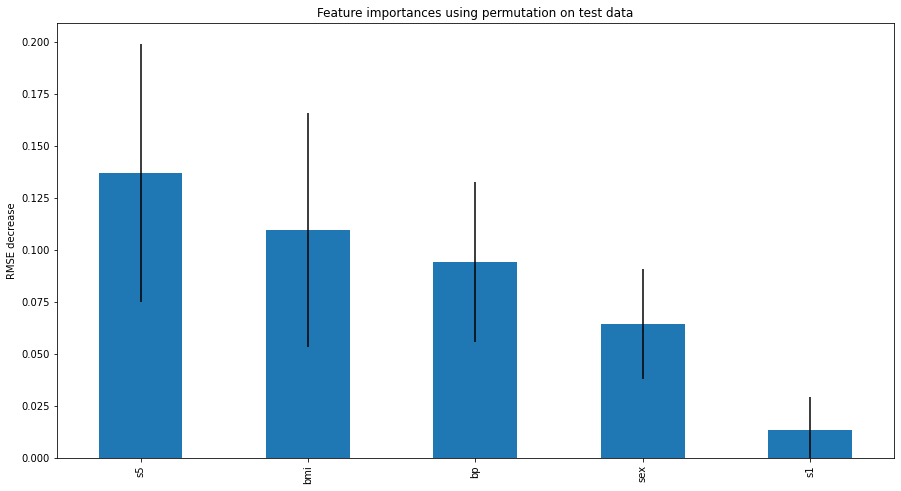

In [16]:
# Perform permutation feature importance using the best ensemble model
permutation_importance_result = permutation_importance(xgboost_regressor, 
                                                       X_test, 
                                                       y_test, 
                                                       n_repeats=10, 
                                                       random_state=seed,)

# Extract the mean and standard deviation of the feature importances from the results and create Pandas Dataframe
forest_importances = pd.DataFrame({"importances" : permutation_importance_result.importances_mean, 
                                   "stdev" : permutation_importance_result.importances_std }, 
                                   index=diabetes_data['feature_names']).sort_values("importances", ascending=False).iloc[:5]

# Plot the feature importances
fig, ax = plt.subplots(figsize=(15,8))
forest_importances["importances"].plot.bar(yerr=forest_importances.stdev, ax=ax)
ax.set_title("Feature importances using permutation on test data")
ax.set_ylabel("Mean RMSE decrease")
ax.set_ylim(bottom=0)
plt.show()

### **Exercise 3 (Bonus): Use AutoML to Improve RMSE Metric**

In [ ]:
# Define AutoML regression model from Auto-Sklearn
automl = autosklearn.regression.AutoSklearnRegressor(time_left_for_this_task=120,
                                                     metric=autosklearn.metrics.root_mean_squared_error)

# Fit AutoML regression model 
automl.fit(X_train, y_train)

# Calculate root mean square error of the train and test sets
train_rmse = get_rmse(automl, X_train, y_train)
test_rmse = get_rmse(automl, X_test, y_test)

# Verbose
print("Train set root mean squared error is: {} and test set root mean squared error is: {}".format(round(train_rmse, 4), 
                                                                                                    round(test_rmse, 4)))

# Verbose Final Model Leaderboard from AutoML
print(automl.leaderboard())

Train set root mean squared error is: 49.3364 and test set root mean squared error is: 56.0331
          rank  ensemble_weight           type       cost  duration
model_id                                                           
25           1             0.66            sgd  51.472196  0.557539
49           2             0.08  liblinear_svr  51.999036  0.569245
48           3             0.14  liblinear_svr  53.439187  0.550245
11           4             0.12  random_forest  55.999621  7.964592
